In [1]:
import numpy as np
import torch
import torch.nn as nn
from torchmetrics import PeakSignalNoiseRatio
from utils.ssim import get_SSIM
from lucyd import LUCYD
from torchvision import models, transforms, datasets
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import wandb
from types import SimpleNamespace
import torchvision.transforms.functional as TF

In [13]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data_dir_blurred, data_dir_gt, filenames):
        self.data_dir_blurred = data_dir_blurred
        self.data_dir_gt = data_dir_gt
        self.filenames = filenames
        #self.transform = transform
    
    def transform(self, blurred, gt):
        # # Resize
        # resize = transforms.Resize(size=(520, 520))
        # image = resize(image)
        # mask = resize(mask)

        # Random crop
        i, j, h, w = transforms.RandomCrop.get_params(
            blurred, output_size=config.img_size)
        blurred = TF.crop(blurred, i, j, h, w)
        gt = TF.crop(gt, i, j, h, w)

        # Transform to tensor
        blurred = TF.to_tensor(blurred)
        gt = TF.to_tensor(gt)

        blurred = blurred
        gt = gt

        return blurred, gt
        
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        image_name = self.filenames[idx]
        image_path_blurred = os.path.join(self.data_dir_blurred, image_name)
        image_path_gt = os.path.join(self.data_dir_gt, image_name)
        
        image_blurred = Image.open(image_path_blurred).convert("L")  # Convert to grayscale
        image_gt = Image.open(image_path_gt).convert("L")
        input_image, gt_image = self.transform(image_blurred, image_gt)
                
        return input_image, gt_image

In [14]:
# Let's define a config object to store our hyperparameters
config = SimpleNamespace(
        epochs = 200,
        batch_size = 4,
        img_size = (512,512),
        lr = 1e-3,
        betas = (0.9, 0.999),
        valid_pct = 0.2,
        start_ckpt = '/home/plankton/underwater-lucyd/models/lucyd-edof-plankton.pth',
        best_loss = 0.03866,
    )
    
data_dir = '/home/plankton/Data/edof_sim'
data_dir_blurred = os.path.join(data_dir, 'blurred')  # Path to the folder containing blurred images
data_dir_gt = os.path.join(data_dir, 'gt')  # Path to the folder containing ground truth images

blurred_filenames = os.listdir(data_dir_blurred)
train_blurred_filenames, val_blurred_filenames = train_test_split(blurred_filenames, test_size=config.valid_pct, random_state=42)  # Adjust test_size and random_state

image_datasets = {
        'train': CustomDataset(data_dir_blurred, data_dir_gt, train_blurred_filenames),
        'val': CustomDataset(data_dir_blurred, data_dir_gt, val_blurred_filenames)
    }

dataloaders = {
        'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=config.batch_size, shuffle=True, num_workers=4),
        'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=config.batch_size, shuffle=False, num_workers=4)
    }

train_dataloader = dataloaders['train']
val_dataloader = dataloaders['val']
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)
    

{'train': 1200, 'val': 300}


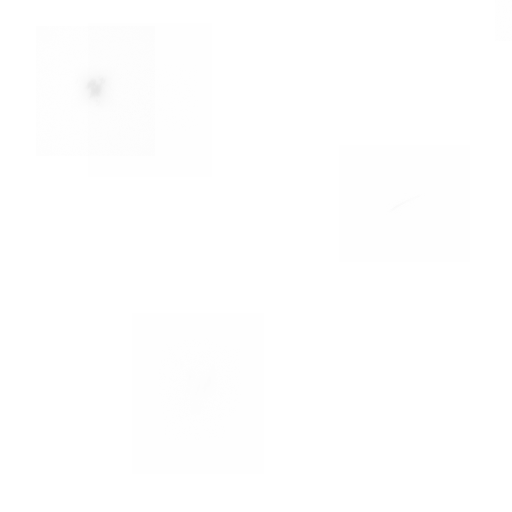

In [28]:
from IPython.display import display
from torchvision import transforms

img = image_datasets['train'][0][0]

# Assuming you have a tensor image 'img' and a transform
transform_to_pil = transforms.ToPILImage()
pil_image = transform_to_pil(img)

# Display the PIL image inline
display(pil_image)
